In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')
from DEDi import ode_find as ode
from DEDi.ODE.PolyLib import PolyFunc
import numpy as np
import matplotlib.pyplot as plt

### Lorenz-96 Model (5D)

The Lorenz-96 system with $N = 5 $ and constant forcing $F = 8$ is defined by:

\begin{align}
\frac{dx_1}{dt} &= (x_2 - x_5)x_4 - x_1 + F \\
\frac{dx_2}{dt} &= (x_3 - x_1)x_5 - x_2 + F \\
\frac{dx_3}{dt} &= (x_4 - x_2)x_1 - x_3 + F \\
\frac{dx_4}{dt} &= (x_5 - x_3)x_2 - x_4 + F \\
\frac{dx_5}{dt} &= (x_1 - x_4)x_3 - x_5 + F \\
\end{align}

Size = (250, 5), dt = 0.04


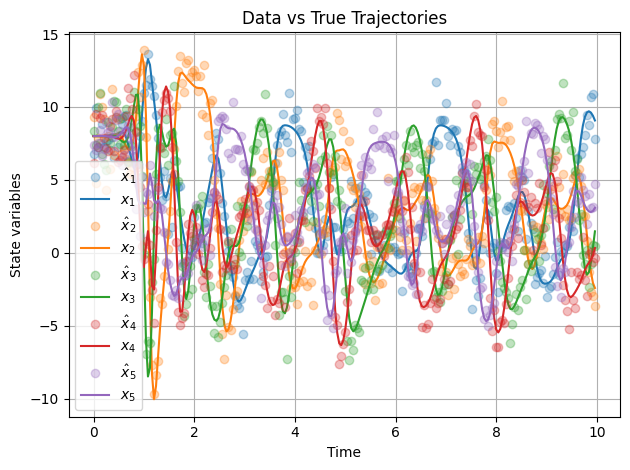

In [2]:
Data = np.load('../_ODEData/Lorenz96Data.npz')
x_data_true_full = Data['x']
t_full = Data['t']

np.random.seed(123)
subsample = 40
x_data_true = x_data_true_full[::subsample]
t = t_full[::subsample]


noise_p, stand_dev = .3, np.std(x_data_true, axis = 0)
x_data = x_data_true + np.random.normal(0,stand_dev*noise_p, size = x_data_true.shape)

# Define validation mask, standard is every third time (33% of data)
validation_mask = np.ones_like(x_data, dtype=bool)
validation_mask[2::3] = False

print(f'Size = {np.shape(x_data)}, dt = {t[1]-t[0]}')
from DEDi.plot_trajectories import plot_trajectory
plot_trajectory(t,x_data,x_data_true)


In [3]:
Library = PolyFunc(num_vars=x_data.shape[1],degree=2,constant=True)
print(Library)

# Initialize Library & Model Discovery
# lambdas,Rs  = 10**(np.linspace(-3, 3, 7)),10**(np.linspace(-4, 0, 5))  #Parameter's used in paper, better to try a simple run first 
lambdas = [10**(-1)]
Rs = [10**(-4)]

discoverode = ode(x_data,Library,[t[0],t[-1]],validation_mask=validation_mask)
discoverode.FindBestModel(lambdas, Rs)

['1', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_1**2', 'x_1*x_2', 'x_1*x_3', 'x_1*x_4', 'x_1*x_5', 'x_2**2', 'x_2*x_3', 'x_2*x_4', 'x_2*x_5', 'x_3**2', 'x_3*x_4', 'x_3*x_5', 'x_4**2', 'x_4*x_5', 'x_5**2']
Setting up Sparse Hessian
Colors Needed = 124
lam = 1.00e-01, R = 1.00e-04, nonzero = 20, val_error = 1.6360e+00,BIC = 3.25e+02, model_error = 9.9694e-04, state_error = 1.3807e+00


In [4]:
models = discoverode.PrintModels(N_best= 1) #Increase cutoff to see other models found

<IPython.core.display.Latex object>

L2 Error = 4.915e-02, LInf Error = 1.406e-01, TPR = 100%


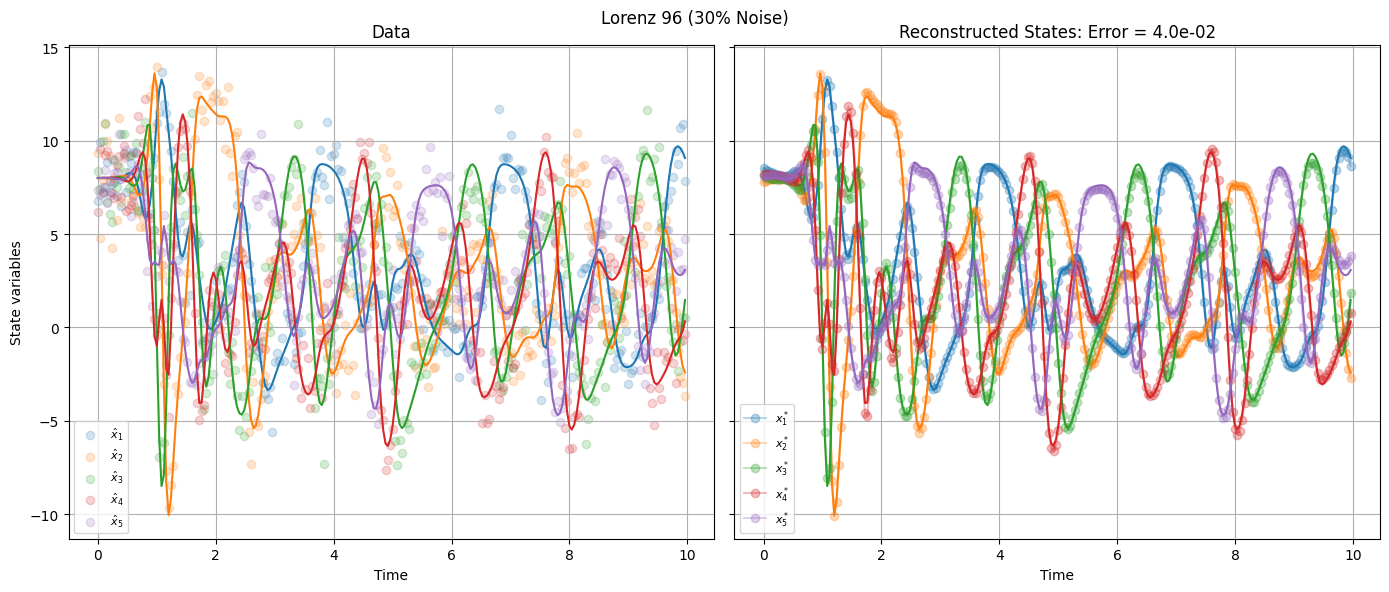

In [5]:
opt_params, opt_NL_params, opt_states = discoverode.best_model()

from _ODEData.Functions.ODEFuncs import generate_coeff_matrix, getlorenz96coeffs, Report_Errors
true_coeffs = generate_coeff_matrix(Library, getlorenz96coeffs())
L2_error, LInf_error, true_positivity_ratio = Report_Errors(true_coeffs, opt_params)
print(f"L2 Error = {L2_error:.3e}, LInf Error = {LInf_error:.3e}, TPR = {int(true_positivity_ratio*100)}%")

from DEDi.plot_trajectories import plot_solution
plot_solution(t,x_data,opt_states,x_data_true, title= f"Lorenz 96 ({int(noise_p*100)}% Noise)")